# 1. 预处理、制作数据集

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import os
import nibabel as nib
import torch

def normalization(data):
    _range = np.nanmax(data) - np.nanmin(data)
    data = (data - np.nanmin(data)) / _range
    return data


def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma



In [2]:

class beta_dataset(Dataset):
    def __init__(self,rootdir):
        self.classes = ['HRP','HC']
        self.samples = []
        for label in os.listdir(rootdir):
            for sample in os.listdir(os.path.join(rootdir,label)):
                
                ''' get label '''
                if label == 'HRP':
                    sample_label = 0
                else:
                    sample_label = 1
                    
                ''' preprocessing '''
                rawimg = nib.load(os.path.join(rootdir,label,sample))
                rawimg = np.array(rawimg.get_fdata())
                rawimg = normalization(rawimg)
                is_nan = np.isnan(rawimg)
                rawimg[is_nan] = 0
                tensorimg = torch.from_numpy(rawimg)
                tensorimg = tensorimg.permute(2,0,1)
                tensorimg_ex = torch.empty(1,79,79,95)
                tensorimg_ex[0] = tensorimg
                
                self.samples.append((tensorimg_ex,sample_label))
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self,idx):
        return self.samples[idx]

dataset = beta_dataset('D:\\betadata')

print(len(dataset))
print(dataset[2][0].shape)

25
torch.Size([1, 79, 79, 95])


## 数据集可视化

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


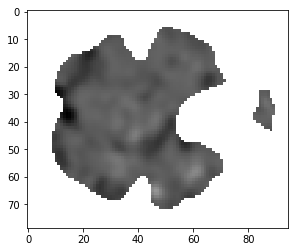

In [3]:
img_vi = dataset[0][0][0,25,:,:]
plt.imshow(img_vi,cmap='Greys')
print(img_vi)

## Dataloader 以及 可视化

torch.Size([3, 1, 79, 79, 95])
torch.Size([83, 293, 3])


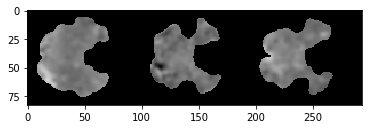

In [4]:
from torch.utils.data import DataLoader
import torchvision
dataloader = DataLoader(dataset, batch_size =3, shuffle = True,num_workers=0)

img_vi2 = next(iter(dataloader))
print(img_vi2[0].shape)

img_vi2_axial = img_vi2[0][:,:,25,:,:]
showimg = torchvision.utils.make_grid(img_vi2_axial)
showimg = showimg.permute(1,2,0)
print(showimg.shape)
plt.imshow(showimg)

# 2. 构建CNN网络，训练

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(in_channels=1,out_channels=3,kernel_size=3,stride=1,padding=1)
        self.pool = nn.MaxPool3d(2,2)
        self.conv2 = nn.Conv3d(in_channels=3,out_channels=6,kernel_size=3,stride=1,padding=1)
        self.fc1 = nn.Linear(6*19*19*23,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        self.fc4 = nn.Linear(10,2)
        self.dropout = nn.Dropout(p=0.6)
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,6*19*19*23)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

net = Net()

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr =0.001, momentum= 0.9)

In [7]:
for epoch in range(1):
    
    running_loss = 0.00
    for i,data in enumerate(dataloader,0):
        inputs, labels = data
        
        optimizer.zero_grad()
        
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        print('loss:%.3f' % (running_loss))
        running_loss = 0

loss:0.698
loss:0.696
loss:0.687
loss:0.654
loss:0.719
loss:0.624
loss:0.709
loss:0.665
loss:0.736


In [8]:
correct = 0
total = 0
with torch.no_grad():
    for data in dataloader:
        imgs, labs = data
        outputs = net(imgs)
        print(outputs)
        print(labs)
        ind, predicted = torch.max(outputs.data, 1)
        total += labs.size(0)
        correct += (predicted == labs).sum().item()

print('Accuracy of the network on the images: %d %%' % (
    100 * correct / total))

tensor([[-0.2983, -0.2893],
        [-0.2727, -0.3390],
        [-0.3422, -0.2653]])
tensor([1, 1, 1])
tensor([[-0.3171, -0.2580],
        [-0.3030, -0.2485],
        [-0.2708, -0.2040]])
tensor([1, 1, 0])
tensor([[-0.2185, -0.2374],
        [-0.2100, -0.2595],
        [-0.3082, -0.2674]])
tensor([0, 1, 0])
tensor([[-0.2788, -0.2108],
        [-0.2988, -0.2514],
        [-0.2422, -0.3886]])
tensor([1, 1, 0])
tensor([[-0.2515, -0.4265],
        [-0.2984, -0.2426],
        [-0.1863, -0.3075]])
tensor([0, 0, 0])
tensor([[-0.2923, -0.2345],
        [-0.1776, -0.2946],
        [-0.2045, -0.4356]])
tensor([1, 0, 0])
tensor([[-0.2624, -0.3468],
        [-0.0919, -0.4513],
        [-0.1611, -0.3403]])
tensor([1, 1, 0])
tensor([[-0.2362, -0.4018],
        [-0.1434, -0.3438],
        [-0.2417, -0.3798]])
tensor([1, 0, 1])
tensor([[-0.1533, -0.3357]])
tensor([0])
Accuracy of the network on the images: 64 %


In [9]:
Saving_path = 'D:/PYTORCH_CODE/beta_net.pth'
torch.save(net.state_dict(),Saving_path)